# Decision trees
Decision trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of the label of unseen data by learning simple decision rules inferred from the data features.

You can understand it as using a set of _if-then-else_ decision rules, e.g., _if_ it snowed in London, _then_ many Londoners would ski on Primrose Hill. _Else_, they would walk in Hyde Park.
Generally speaking, the deeper the tree, i.e., the more _if-then-else_ decisions are subsequently made in our model, the more complex the decision rules and the fitter the model. However, note that decision trees are prone to overfitting. 

<a name="section-1"></a>

## Section 1: Data Preparation

In this notebook, we will use decision trees as a classification algorithm with the GINI-index, and work with the famous [Iris data set](https://en.wikipedia.org/wiki/Iris_flower_data_set). It contains four biological characteristics _(features)_ of 150 samples that belong to three species _(classes)_ of the family of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). The data set provides 50 samples for each species.

In [1]:
# import packages
from collections import defaultdict
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

In [2]:
# load data
data = load_iris()
# print data to see how it is structured
#print(data)
X, y, column_names = data['data'], data['target'], data['feature_names']
# combining all information in one data frame
X_y = pd.DataFrame(X, columns=column_names)
X_y['label'] = y

In [3]:
# check
X_y.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


It is always a good idea to see whether the features are correlated. The python package `seaborn` has a nice one-line command to explore this visually. It directly prints the feature names (sepal length, sepal width, petal length, petal width) and labels as axis titles.

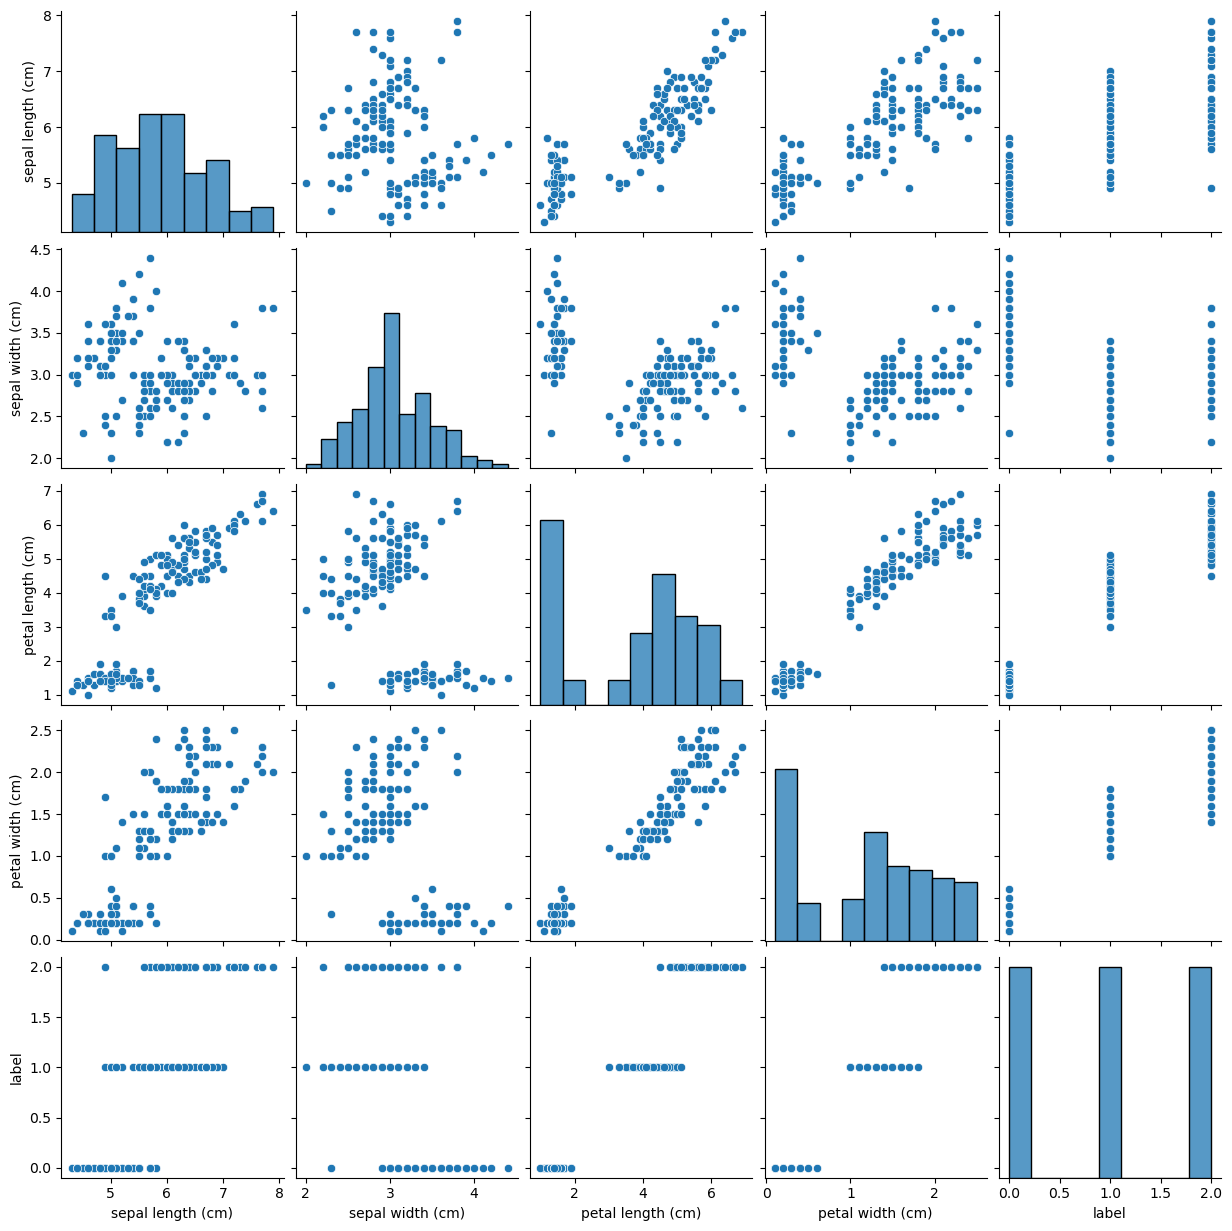

In [4]:
import seaborn as sns

sns.pairplot(X_y);

As with any other supervised machine learning method, we create a train and test set to learn and evaluate our model, respectively.

In [5]:
# stacking data X and labels y into one matrix
X_y_shuff = X_y.iloc[np.random.permutation(len(X_y))]

# we split train to test as 70:30
split_rate = 0.7
train, test = np.split(X_y_shuff, [int(split_rate*(X_y_shuff.shape[0]))])

X_train = train[train.columns[:-1]]
y_train = train[train.columns[-1]]

X_test = test[test.columns[:-1]]
y_test = test[test.columns[-1]]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

training_weights = np.ones_like(y_train) / len(y_train)

# We need a dictionary indicating whether the column index maps to a 
# categorical feature or numerical
# In this example, all features are numerical (categorical=False)
columns_dict = {index: False for index in range(X_train.shape[1])}




<a name="section-2"></a>

## Section 2: Intro to Decision Trees and GINI-index




- Decision tree algorithm is a _greedy algorithm_ that splits the data samples $\boldsymbol y$ into _left_ $\boldsymbol y_l$ and _right_ $\boldsymbol y_r$ samples, and the splitting is applied recursively on each side, resulting in a binary-tree like of splittings.
- Samples can be split given two parameters: the feature index $j$ and a value $s$.
  - **If the feature is a continuous variable**, the $s$ is used as a threshold such that samples with feature value less than $s$ are assigned to the left, and vice versa.
  - **if the feature is a categorical variable**, the $s$ is used as a predicate such that samples with feature value equals to $s$ are assigned to left, and vice versa.
- To determine $j$ and $s$ at each split node, we may use _GINI-index_ to search for $j$ and $s$ that minimizes the weighted sum of _GINI-index_ of the left side samples and right side samples:
  
  $$GI(\boldsymbol y; j, s) = p_l \times GI(\boldsymbol y_l) + p_r \times GI(\boldsymbol y_r)$$

where $p_l$ and $p_r$ are, respectively, the cumulative weights of samples on the left and on the right, while $GI(\boldsymbol y)$ is defined as:

$$
\text{GI}(\boldsymbol y) = 1 - \sum_{i=1}^Q \mathbb P (y = c_i)^2
$$

where $c_i$ is the i-th class out of $Q$ distinct classes, so $\mathbb P (y = c_i)$ reads the weight of the class $i$ in the current sample $\boldsymbol y$.


There are other alternatives to _GINI-index_ like _Information Gain_ but we will stick to _GINI-index_ in this notebook.



In [6]:
def gini_index(y, sample_weights):
  """ 
  Calculate the GINI-index for labels.
  Arguments:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (float): the GINI-index for y.
  """

  # count different labels in y，and store in label_weights
  # initialize with zero for each distinct label.
  label_weights = {yi: 0 for yi in set(y)}  
  for yi, wi in zip(y, sample_weights):
      label_weights[yi] += wi

  total_weight = sum(label_weights.values())
  gini = 1 
  for label, weight in label_weights.items():
      gini -= (weight / total_weight)**2

  return gini

In [7]:
# evaluate labels y
gini_index(y_train.to_numpy(), training_weights)

0.665034013605442

<a name="section-3"></a>

## Section 3: Decision Tree Training


Next, we define a function to split the data samples based on a feature (column) index and a value (recall how this value will be used whether the feature is categorical or numerical). 

This has not much use yet, but we will call it in later functions, e.g., in the next cell in `gini_split_value`.

In [8]:
def split_samples(X, y, sample_weights, column, value, categorical):
  """
  Return the split of data whose column-th feature:
    1. equals value, in case `column` is categorical, or
    2. less than value, in case `column` is not categorical (i.e. numerical)

  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for splitting.
      value: splitting threshold  the samples 
      categorical: boolean value indicating whether column is a categorical variable or numerical.
  Returns:
      tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
  """ 

  if categorical:
    left_mask =(X[:, column] == value)
  else:
    left_mask = (X[:, column] < value)
  
  X_left, X_right = X[left_mask, :], X[~left_mask, :]
  y_left, y_right = y[left_mask], y[~left_mask]
  w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

  return (X_left, X_right), (y_left, y_right), (w_left, w_right)

For a given feature index, we need to estimate the best value $s$ to use as threshold (for numerical variables) or predicate (for categorical variables). We need to implement the function the searches for $s$ that minimizes the _GINI-index_. We can do this by calling our previously defined two functions `split_samples` and `gini_index`. 

In [9]:
def gini_split_value(X, y, sample_weights, column, categorical):
  """
  Calculate the GINI-index based on `column` with the split that minimizes the GINI-index.
  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
      categorical: boolean value indicating whether column is a categorical variable or numerical.
  Returns:
      (float, float): the resulted GINI-index and the corresponding value used in splitting.
  """
  
  unique_vals = np.unique(X[:, column])

  assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

  gini_index_val, threshold = np.inf, None
  
  # split the values of i-th feature and calculate the cost 
  for value in unique_vals:
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical) 

    # if one of the two sides is empty, skip this split.
    if len(y_l) == 0 or len(y_r) == 0:
      continue
    
    p_left = sum(w_l)/(sum(w_l) + sum(w_r))
    p_right = 1 - p_left
    new_cost = p_left * gini_index(y_l, w_l) + p_right * gini_index(y_r, w_r) 
    if new_cost < gini_index_val:
      gini_index_val, threshold = new_cost, value
    
  return gini_index_val, threshold

In [10]:
# evaluate for feature sepal width (cm)
gini_split_value(X_train.to_numpy(), y_train.to_numpy(), training_weights, 3, columns_dict[3])

(0.318407960199005, 1.0)

We choose the best feature to split by calling the function `gini_split_value` for each feature.

In [11]:
def gini_split(X, y, sample_weights, columns_dict):
  """
  Choose the best feature to split according to criterion.
  Args:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
  Returns:
      (int, float): the best feature index and value used in splitting. 
      If the feature index is None, then no valid split for the current Node.
  """

  # UPDATED LINE: initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
  min_gini_index, split_column, split_val = np.inf, None, 0
  for column, categorical in columns_dict.items():
      # skip column if samples are not seperable by that column.
      if len(np.unique(X[:, column])) < 2:
        continue
      gini_index, val = gini_split_value(X, y, sample_weights, column, categorical)        
      if gini_index < min_gini_index:
          min_gini_index, split_column, split_val = gini_index, column, val

  return split_column, split_val

In [12]:
# evaluate which feature is best
gini_split(X_train.to_numpy(), y_train.to_numpy(), training_weights, columns_dict)

(2, 3.0)

Now, we need a function that returns the label which appears the most in our label variable `y`.

In [13]:
def majority_vote(y, sample_weights):
  """
  Return the label which appears the most in y.
  Args:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (int): the majority label
  """
  majority_label = {yi: 0 for yi in set(y)}

  for yi, wi in zip(y, sample_weights):
    majority_label[yi] += wi
  return max(majority_label, key=majority_label.get)

In [14]:
# evaluate it
majority_vote(y_train.to_numpy(), training_weights)

0

Finally, we can build the decision tree by using `choose_best_feature` to find the best feature to split the `X`, and `split_dataset` to get sub-trees.

In [15]:

def build_tree(X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=2):
  """Build the decision tree according to the data.
  Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
  Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
  """
  # include a clause for the cases where (i) no feature, (ii) all labels are the same, (iii) depth exceed, or (iv) X is too small
  if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf: 
      return {'majority_label': majority_vote(y, sample_weights)}
  
  split_index, split_val = gini_split(X, y, sample_weights, columns_dict) 

  # If no valid split at this node, use majority vote.
  if split_index is None:
    return {'majority_label': majority_vote(y, sample_weights)}

  categorical = columns_dict[split_index]
  (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical)
  return {
      'feature_name': feature_names[split_index],
      'feature_index': split_index,
      'value': split_val,
      'categorical': categorical,
      'majority_label': None,
      'left': build_tree(X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
      'right': build_tree(X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
  }

We define a wrapper function that we call `train` to call this `build_tree` function with the appropriate arguments.

In [16]:
def train(X, y,  columns_dict, sample_weights=None):
  """
  Build the decision tree according to the training data.
  Args:
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
  """
  if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
      sample_weights = np.ones(X.shape[0]) / X.shape[0]
  else:
      sample_weights = np.array(sample_weights) / np.sum(sample_weights)

  feature_names = X.columns.tolist()
  X = X.to_numpy()
  y = y.to_numpy()
  return build_tree(X, y, sample_weights, columns_dict, feature_names, depth=1)

In [17]:
# fit the decision tree with training data
tree = train(X_train, y_train, columns_dict)

In [18]:
tree

{'feature_name': 'petal length (cm)',
 'feature_index': 2,
 'value': 3.0,
 'categorical': False,
 'majority_label': None,
 'left': {'majority_label': 0},
 'right': {'feature_name': 'petal length (cm)',
  'feature_index': 2,
  'value': 4.8,
  'categorical': False,
  'majority_label': None,
  'left': {'majority_label': 1},
  'right': {'feature_name': 'petal width (cm)',
   'feature_index': 3,
   'value': 1.8,
   'categorical': False,
   'majority_label': None,
   'left': {'feature_name': 'petal length (cm)',
    'feature_index': 2,
    'value': 5.0,
    'categorical': False,
    'majority_label': None,
    'left': {'majority_label': 1},
    'right': {'feature_name': 'petal width (cm)',
     'feature_index': 3,
     'value': 1.6,
     'categorical': False,
     'majority_label': None,
     'left': {'majority_label': 2},
     'right': {'feature_name': 'sepal length (cm)',
      'feature_index': 0,
      'value': 7.2,
      'categorical': False,
      'majority_label': None,
      'left': {

<a name="section-4"></a>

## Section 4: Decision Tree Classification Algorithm


Now, we want to use this fitted decision tree to make predictions for our test set `X_test`. To do so, we first define a function `classify` that takes each single data point `x` as an argument. We will write a wrapper function `predict` that calls this `classify` function.

In [19]:
def classify(tree, x):
  """
  Classify a single sample with the fitted decision tree.
  Args:
      x: ((pd.Dataframe) a single sample features, of shape (D,).
  Returns:
      (int): predicted testing sample label.
  """
  if tree['majority_label'] is not None: 
    return tree['majority_label']

  elif tree['categorical']:
    if x[tree['feature_index']] == tree['value']:
      return classify(tree['left'], x)
    else:
      return classify(tree['right'], x)

  else:
    if x[tree['feature_index']] < tree['value']:
      return classify(tree['left'], x)
    else:
      return classify(tree['right'], x)

In [20]:
def predict(tree, X):
  """
  Predict classification results for X.
  Args:
      X: (pd.Dataframe) testing sample features, of shape (N, D).
  Returns:
      (np.array): predicted testing sample labels, of shape (N,).
  """
  if len(X.shape) == 1:
      return classify(tree, X)
  else:
      return np.array([classify(tree, x) for x in X])

To evaluate how well the tree can generalise to unseen data in `X_test`, we define a short function that computes the mean accuracy.

In [21]:
def tree_score(tree, X_test, y_test):
  y_pred = predict(tree, X_test) 
  return np.mean(y_pred==y_test)

In [22]:
print('Training accuracy:', tree_score(tree, X_train.to_numpy(), y_train.to_numpy()))
print('Test accuracy:', tree_score(tree, X_test.to_numpy(), y_test.to_numpy()))

Training accuracy: 0.9904761904761905
Test accuracy: 0.9555555555555556


<a name="section-5"></a>

## Section 5: From Decision Tree to Random Forest

Note
  - **training-samples** used to mean the rows in `X_train` in other occasions, and we will use **training-examples** or **training-instances** instead to avoid confusion with
  - a **random-sample**, which means a selection of instances by chance from a group of instances. 

It is now the time to build ensemble model from individual models for the first time in this course, applied to ensemble of decision trees. 


One approach
for ensemble methods is [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). In particular we can apply bootstrapping for multiple decision trees upon two levels:

1. Bootstrap on the training-instances: each model is trained on a random-sample (**with replacement**) from the training-instances. Eventually, as learned from lecture notes, decisions are aggregated across the models, hence the name _bagging_ (Bootstrap Aggregate).

  Note that for each decision tree we randomly-sample from training-instances **with replacement** and the size of each random-sample is the same size of the training-instances. This will basically allow some training-instances to be duplicated and other instances to be excluded.
2. Feature bagging: at each split, a subset of features are considered before searching for the best split column $j$ and value $s$.


The image below illustrates random forest construction from individual decision trees. Notice the random-sampling that occurs at two levels:

1. At red-stars: bootstrapping (random-sampling with replacement) of training-instances.
2. At blue-circles: random-sampling without replacement of features at each split node.

![rf](https://drive.google.com/uc?export=view&id=19LdaNVHlSp7WlHw7DfaMxu38fEJ7RIxW)

This design will leave us two hyperparameters for random forest:

1. $B$: number of decision trees.
2. `n_features`: number of features (columns) sampled, **without replacement**, at each split before searching for the best split column $j$ and value $s$. For classification task `n_features` is recommended to be the number of all columns divided by 3.
3. Add to these the decision trees hyperparameters like `max_depth` and `min_leaf_sample`.




The second layer of sampling, i.e. _feature bagging_, requires us to re-implement the `gini_split` function to subsample from the feature columns before searching for the best split.


Modify the following function that will be employed for random forest decision trees to find the best split column $j$ (out from sampled `n_features` columns) and value $s$. Consider using the `gini_split_value` function that was already implemented for individual decision tree implementation.

In [23]:
def gini_split_rf(n_features, X, y, sample_weights, columns_dict):
  """
  Choose the best feature to split according to criterion.
  Args:
      n_features: number of sampled features.
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
  Returns:
      (float, int, float): the minimized gini-index, the best feature index and value used in splitting.
  """
  columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
  columns_dict = {c: columns_dict[c] for c in columns}

  min_gini_index, split_column, split_val = np.inf, 0, 0
  for column, categorical in columns_dict.items():
    # skip column if samples are not seperable by that column.
    if len(np.unique(X[:, column])) < 2:
      continue

    # search for the best splitting value for the given column.
    gini_index, val = gini_split_value(X, y, sample_weights, column, categorical)     
    if gini_index < min_gini_index:
        min_gini_index, split_column, split_val = gini_index, column, val

  return min_gini_index, split_column, split_val

Since `build_tree` depends on `gini_split`, we need to slightly modify it to call `gini_split_rf` instead.

In [24]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=2):
  """Build the decision tree according to the data.
  Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
  Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
  """
  # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
  if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
      return {'majority_label': majority_vote(y, sample_weights)}
  
  else:
    GI, split_index, split_val = gini_split_rf(n_features, X, y, sample_weights, columns_dict)  
    
    # If GI is infinity, it means that samples are not seperable by the sampled features.
    if GI == np.inf:
      return {'majority_label': majority_vote(y, sample_weights)}
    categorical = columns_dict[split_index]
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical) 
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'majority_label': None,
        'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

Now it is time to write the training function the constructs multiple decision trees, each operating on a subset of samples (with replacement).

In [25]:
def train_rf(B, n_features, X, y,  columns_dict, sample_weights=None):
  """
  Build the decision tree according to the training data.
  Args:
      B: number of decision trees.
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
  """
  if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
      sample_weights = np.ones(X.shape[0]) / X.shape[0]
  else:
      sample_weights = np.array(sample_weights) / np.sum(sample_weights)

  feature_names = X.columns.tolist()
  X = X.to_numpy()
  y = y.to_numpy()
  N = X.shape[0]
  training_indices = np.arange(N)
  trees = []

  for _ in range(B):
    sample = np.random.choice(training_indices, N, replace=True)
    X_sample = X[sample, :]
    y_sample = y[sample]
    w_sample = sample_weights[sample]
    tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict, feature_names, depth=1)
    trees.append(tree)

  return trees

Let's write the prediction function which aggregates the decision from all decision trees and returns the class with highest probability.

In [26]:
def predict_rf(rf, X):
  """
  Predict classification results for X.
  Args:
      rf: A trained random forest through train_rf function.
      X: (pd.Dataframe) testing sample features, of shape (N, D).
  Returns:
      (np.array): predicted testing sample labels, of shape (N,).
  """

  def aggregate(decisions):
    count = defaultdict(int)
    for decision in decisions:
      count[decision] += 1
    return max(count, key=count.get)

  if len(X.shape) == 1:
      return aggregate([classify(tree, X) for tree in rf])
  else:
      return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

In [27]:
def rf_score(rf, X_test, y_test):
  y_pred = predict_rf(rf, X_test) 
  return np.mean(y_pred==y_test)

In [28]:
n_features = X_train.shape[1] // 3
B = 50
# fit the random forest with training data
rf = train_rf(B, n_features, X_train, y_train, columns_dict)

In [29]:
rf_score(rf, X_train.to_numpy(), y_train.to_numpy())

0.9904761904761905

In [30]:
rf_score(rf, X_test.to_numpy(), y_test.to_numpy())

0.9777777777777777